## Цель: EDA → предобработка → масштабирование → KMeans / Hierarchical / DBSCAN → выбор стран нуждающихся в поддержке.

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Быстрая разведка (EDA)
Проверим типы, пропуски и базовые статистики.

In [3]:
df = pd.read_csv("Lab3.csv")

In [4]:
df.head(10)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.440,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.490,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.100,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.400,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.440,76.8,2.13,12200
5,Argentina,14.5,18.9,8.10,16.0,18700,20.900,75.8,2.37,10300
6,Armenia,18.1,20.8,4.40,45.3,6700,7.770,73.3,1.69,3220
7,Australia,4.8,19.8,8.73,20.9,41400,1.160,82.0,1.93,51900
8,Austria,4.3,51.3,11.00,47.8,43200,0.873,80.5,1.44,46900
9,Azerbaijan,39.2,54.3,5.88,20.7,16000,13.800,69.1,1.92,5840


In [5]:
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


Inflation - измерение годового темпа роста общего ВВП
есть отрицательные значения

In [6]:
df.info()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

In [7]:
# Настройки отображения
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

cols = ['country', 'child_mort', 'exports', 'health', 'imports',
        'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

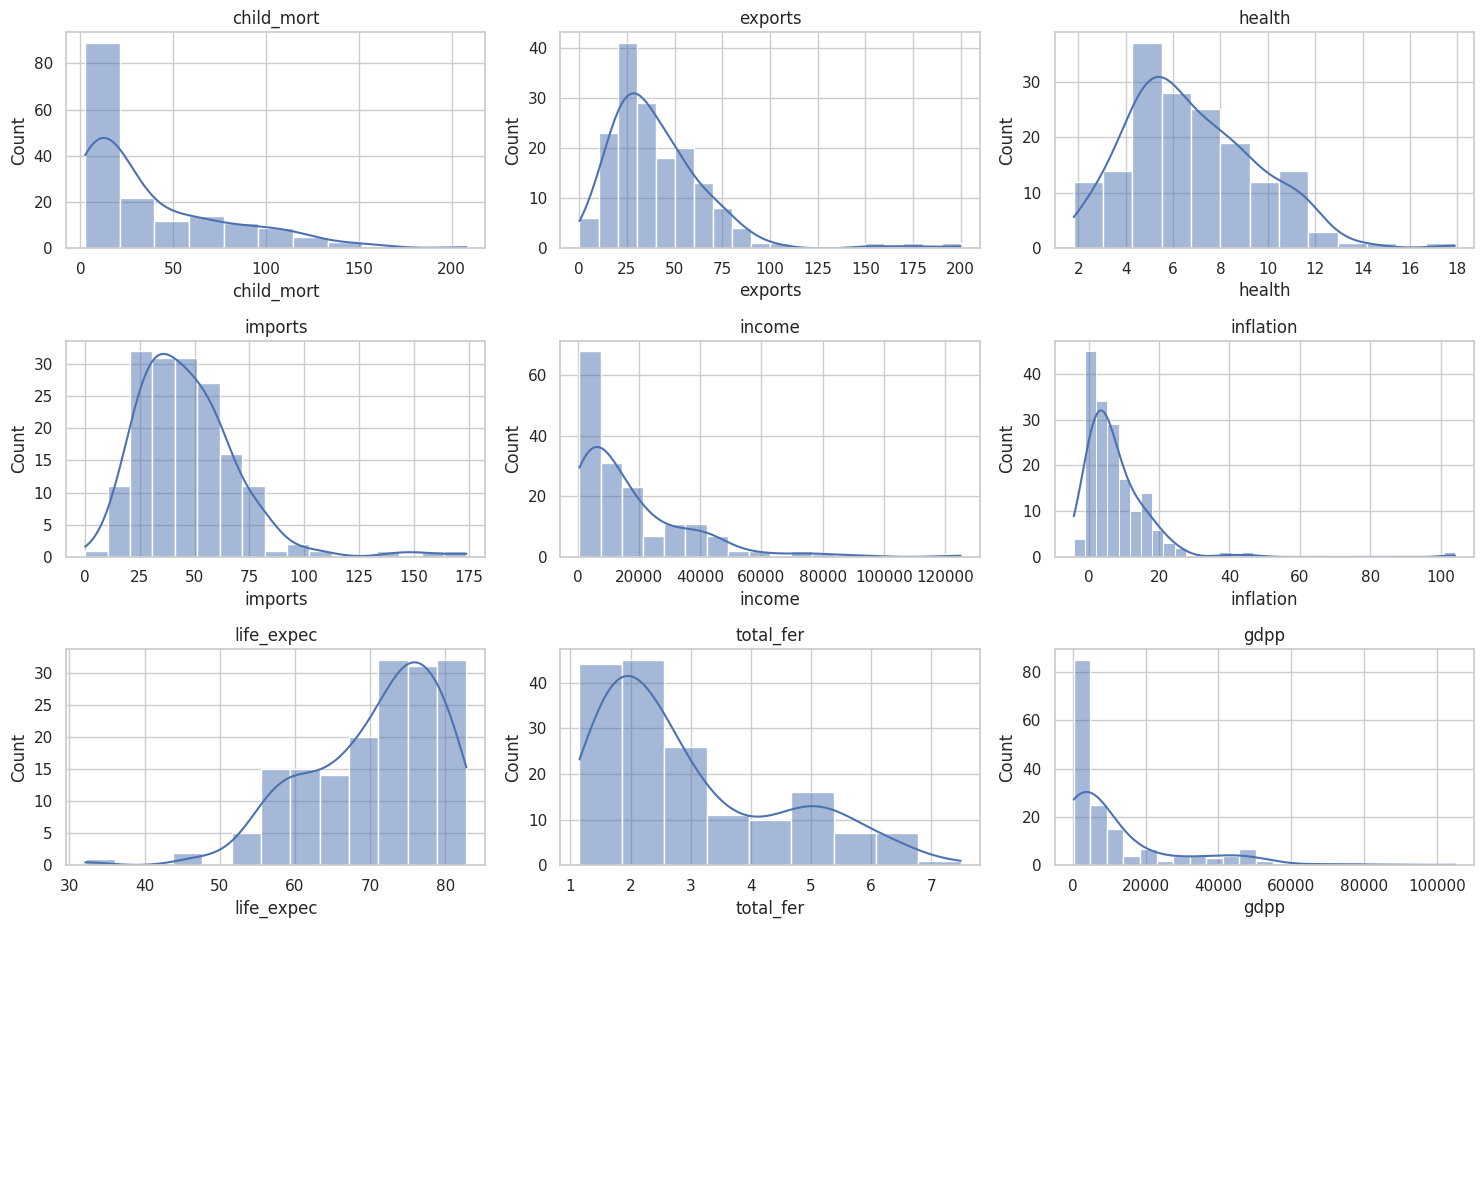

In [8]:
# Гистограммы всех числовых признаков
num_cols = cols[1:]
fig, axes = plt.subplots(len(num_cols)//3 + 1, 3, figsize=(15, 12))
axes = axes.flatten()
for ax, c in zip(axes, num_cols):
    sns.histplot(df[c].dropna(), kde=True, ax=ax)
    ax.set_title(c)
# убираем пустые оси
for ax in axes[len(num_cols):]:
    ax.axis('off')
plt.tight_layout()
plt.show()


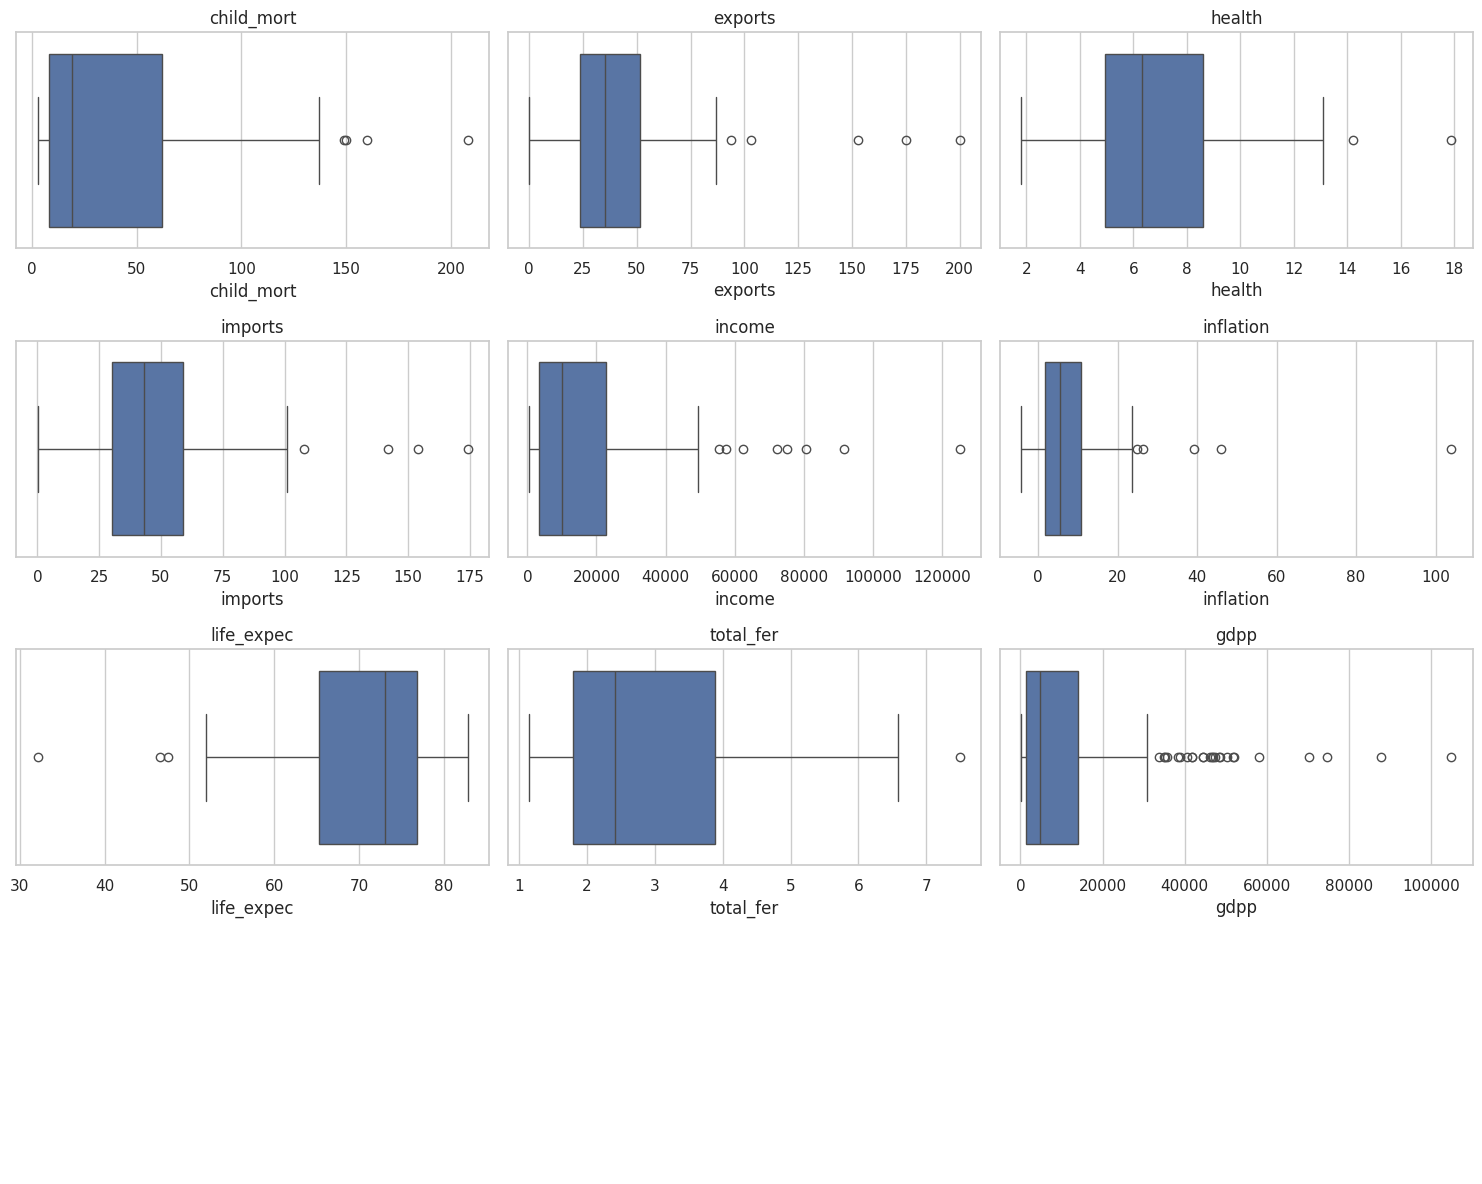

In [9]:
# Boxplots (быстрое сравнение разброса / выбросов)
fig, axes = plt.subplots(len(num_cols)//3 + 1, 3, figsize=(15, 12))
axes = axes.flatten()
for ax, c in zip(axes, num_cols):
    sns.boxplot(x=df[c].dropna(), ax=ax)
    ax.set_title(c)
for ax in axes[len(num_cols):]:
    ax.axis('off')
plt.tight_layout()
plt.show()

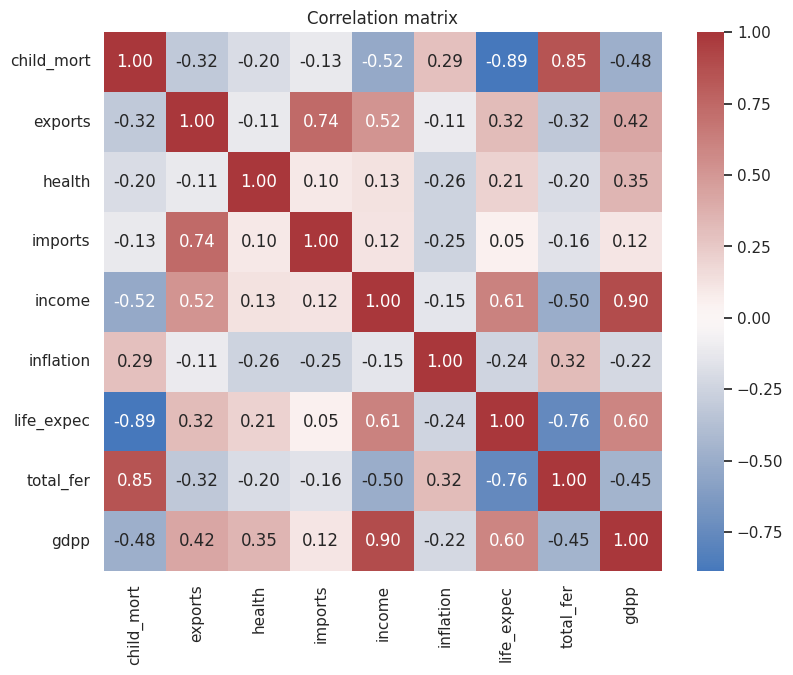

In [ ]:
# Корреляционная матрица
corr = df[num_cols].corr()
plt.figure(figsize=(9, 7))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag', center=0)
plt.title('Correlation matrix')
plt.show()

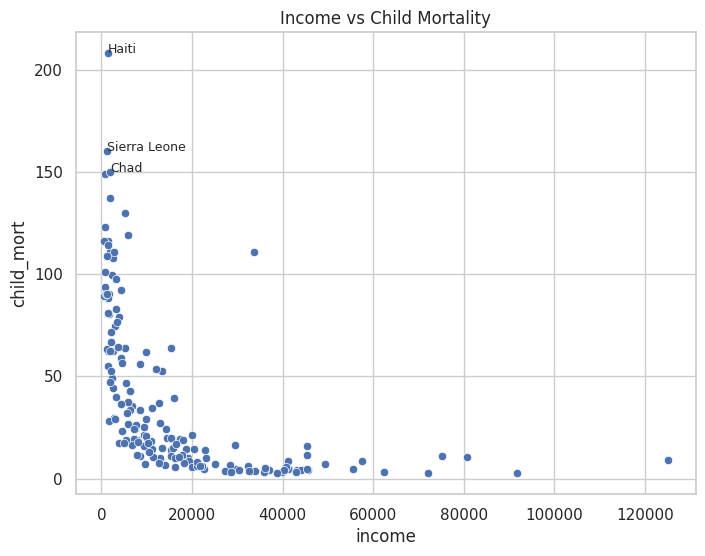

In [ ]:
# Scatter: income vs child_mort
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='income', y='child_mort')
plt.xlabel('income')
plt.ylabel('child_mort')
plt.title('Income vs Child Mortality')
# 3 худших по child_mort
top5 = df.nlargest(3, 'child_mort')
for _, r in top5.iterrows():
    plt.text(r['income'], r['child_mort'], r['country'], fontsize=9)
plt.show()

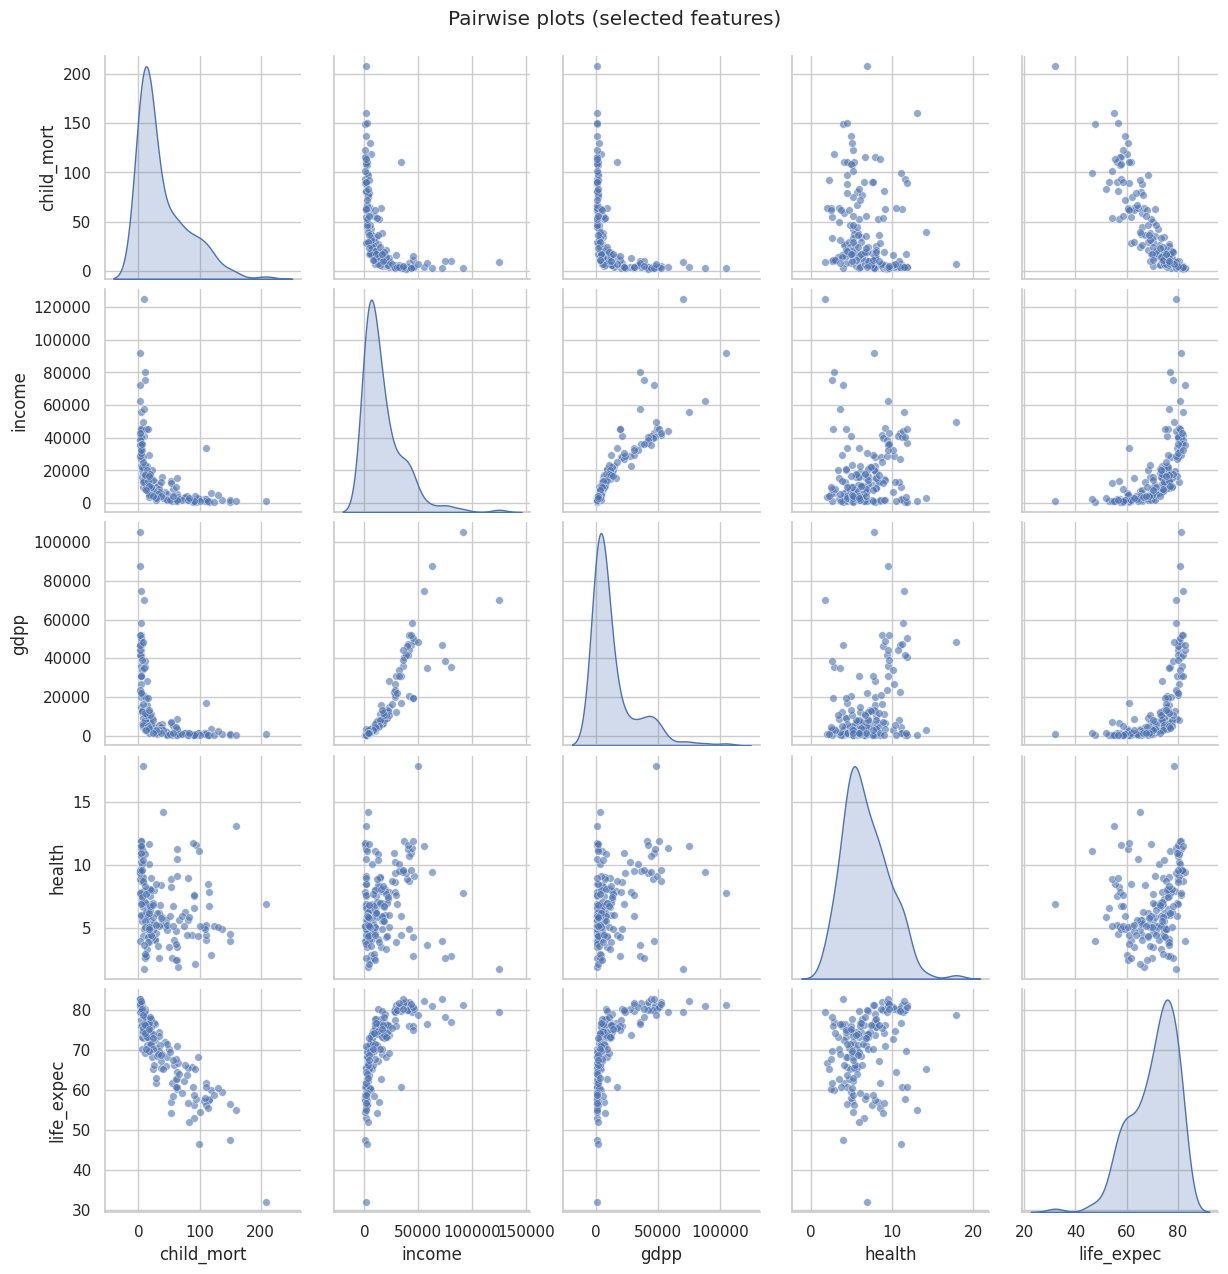

In [12]:
# 5) Pairplot для выбранных ключевых признаков (уменьшаем набор для читаемости)
sel = ['child_mort', 'income', 'gdpp', 'health', 'life_expec']
sns.pairplot(df[sel].dropna(), diag_kind='kde', plot_kws={'s': 30, 'alpha': 0.6})
plt.suptitle('Pairwise plots (selected features)', y=1.02)
plt.show()

## Визуализация 2D для контроля (PCA)
Простая двумерная проекция нужна, чтобы видеть распределение точек и грубые кластеры.

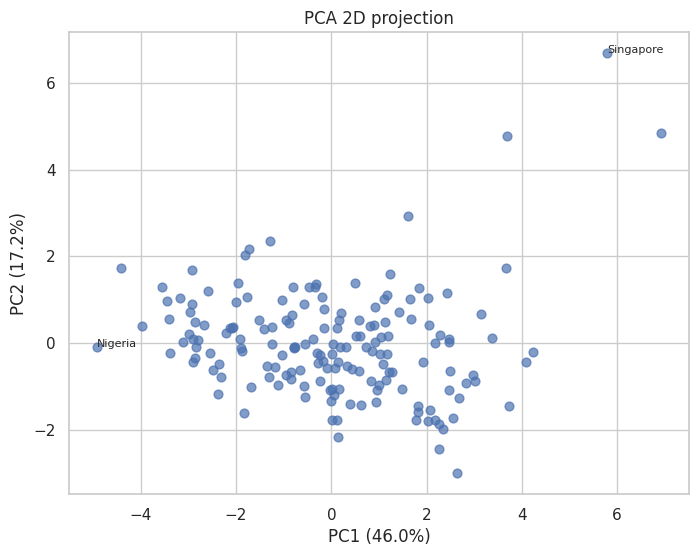

In [13]:
# PCA 2D проекция (предварительно стандартизируем)
X = df[num_cols].dropna()
scaler = StandardScaler()
Xs = scaler.fit_transform(X)
pca = PCA(n_components=2, random_state=0)
proj = pca.fit_transform(Xs)
plt.figure(figsize=(8,6))
plt.scatter(proj[:,0], proj[:,1], s=40, alpha=0.7)
plt.xlabel('PC1 (%.1f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC2 (%.1f%%)' % (pca.explained_variance_ratio_[1]*100))
plt.title('PCA 2D projection')
# подпишем несколько крайних точек (пример)
for i, country in enumerate(X.index):
    if proj[i,0] < proj[:,0].min() + 0.1 or proj[i,1] > proj[:,1].max() - 0.1:
        plt.text(proj[i,0], proj[i,1], df.loc[country,'country'], fontsize=8)
plt.show()

## K-Means: подбор k (Elbow + Silhouette)
Мы пробуем k=2..8. Elbow — смотри «излом» на графике инерции. Silhouette — выбираем k с максимальным средним силуэтом.

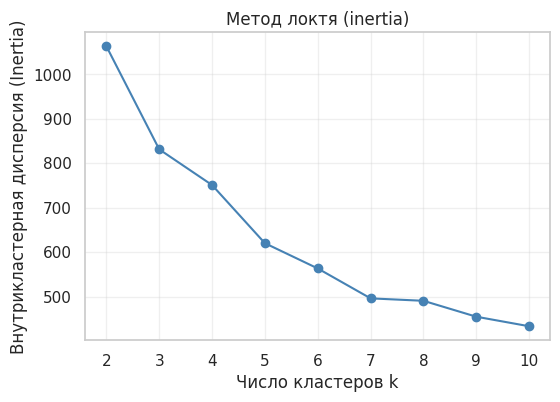

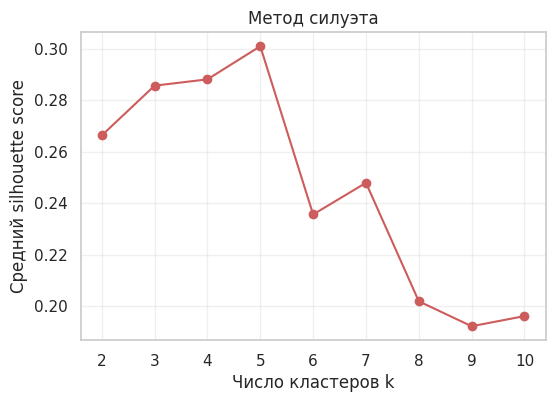

In [14]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score

inertias = []
silhouettes = []
K = range(2, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(Xs)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(Xs, labels))

# --- Метод локтя ---
plt.figure(figsize=(6,4))
plt.plot(K, inertias, 'o-', color='steelblue')
plt.title('Метод локтя (inertia)')
plt.xlabel('Число кластеров k')
plt.ylabel('Внутрикластерная дисперсия (Inertia)')
plt.grid(True, alpha=0.3)
plt.show()

# --- Метод силуэта ---
plt.figure(figsize=(6,4))
plt.plot(K, silhouettes, 'o-', color='indianred')
plt.title('Метод силуэта')
plt.xlabel('Число кластеров k')
plt.ylabel('Средний silhouette score')
plt.grid(True, alpha=0.3)
plt.show()

In [15]:
# --- Обучение финальной модели ---
best_k = 5
print(f"Оптимальное k по силуэту: {best_k}")

kmeans = KMeans(n_clusters=best_k, random_state=42)
labels_kmeans = kmeans.fit_predict(Xs)

# --- MiniBatchKMeans ---
mbkm = MiniBatchKMeans(n_clusters=best_k, random_state=42, batch_size=32)
labels_mbkm = mbkm.fit_predict(Xs)


Оптимальное k по силуэту: 5


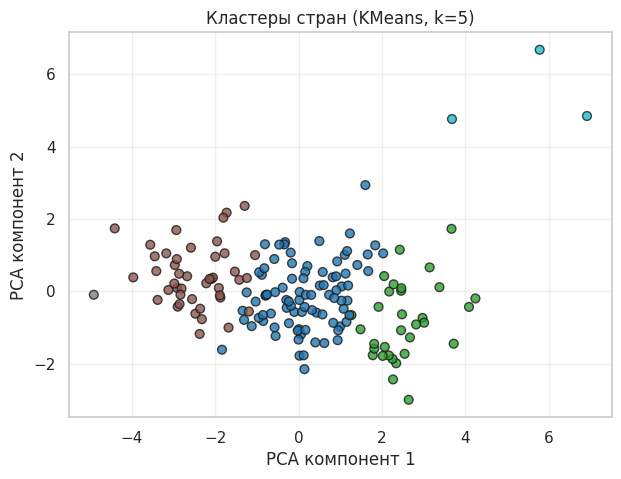

In [16]:
from sklearn.decomposition import PCA

# PCA до 2 компонент
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(Xs)

plt.figure(figsize=(7, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1],
            c=labels_kmeans, cmap='tab10', s=40, alpha=0.8, edgecolor='k')

plt.title(f'Кластеры стран (KMeans, k={best_k})')
plt.xlabel('PCA компонент 1')
plt.ylabel('PCA компонент 2')
plt.grid(True, alpha=0.3)
plt.show()


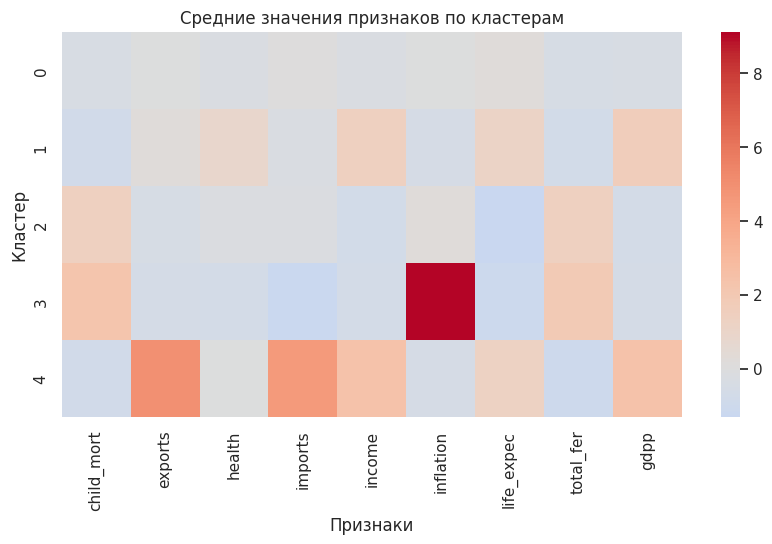

In [17]:
# Добавляем метки кластеров к данным
df_clusters = pd.DataFrame(Xs, columns=df.columns[1:])  # исключаем 'country'
df_clusters['cluster'] = labels_kmeans

# Средние значения признаков по каждому кластеру
cluster_means = df_clusters.groupby('cluster').mean()

plt.figure(figsize=(10, 5))
sns.heatmap(cluster_means, annot=False, cmap='coolwarm', center=0)
plt.title('Средние значения признаков по кластерам')
plt.xlabel('Признаки')
plt.ylabel('Кластер')
plt.show()


In [18]:
df['cluster'] = labels_kmeans
df['cluster'].value_counts().sort_index()


0    87
1    32
2    44
3     1
4     3
Name: cluster, dtype: int64

In [19]:
df.groupby('cluster').mean(numeric_only=True)


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
cluster,,,,,,,,,
0,22.219540,41.083782,6.246667,47.795010,12678.965517,7.727747,72.625287,2.333333,6494.390805
1,5.181250,46.118750,9.088437,40.584375,44021.875000,2.513844,80.081250,1.788437,42118.750000
2,94.313636,28.677500,6.329091,42.872727,3503.250000,9.895568,59.022727,5.047727,1753.909091
3,130.000000,25.300000,5.070000,17.400000,5150.000000,104.000000,60.500000,5.840000,2330.000000
4,4.133333,176.000000,6.793333,156.666667,64033.333333,2.468000,81.433333,1.380000,57566.666667


In [20]:
df.groupby('cluster').median(numeric_only=True)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
cluster,,,,,,,,,
0,18.60,38.40,5.98,49.20,10500.0,5.990,73.50,2.240,4680.0
1,4.20,44.25,9.51,37.25,40100.0,1.105,80.35,1.860,41200.0
2,90.25,23.30,5.48,41.50,1835.0,8.215,59.40,5.085,763.5
3,130.00,25.30,5.07,17.40,5150.0,104.000,60.50,5.840,2330.0
4,2.80,175.00,7.77,154.00,72100.0,3.620,81.30,1.360,46600.0


| Кластер | Ключевые характеристики                                                                | Интерпретация                                                                                                            | Приоритет помощи  |
| ------- | -------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------ | ----------------- |
| **0**   | Умеренная смертность (≈22), средний доход (~12 тыс), жизнь ~73 года, рождаемость 2.3   | **Развивающиеся, но стабильные страны** — имеют средний уровень жизни и здравоохранения, нуждаются в умеренной поддержке | Средний           |
| **1**   | Низкая смертность (~5), высокий доход (~40 тыс), жизнь ~80 лет                         | **Развитые страны** (Европа, США, Канада и др.) — высокая устойчивость, хорошее здравоохранение                          | Низкий            |
| **2**   | Очень высокая смертность (~90), низкий доход (~3.5 тыс), жизнь ~59 лет, рождаемость ~5 | **Беднейшие страны мира** (Сахара, Центральная Африка) — нуждаются в приоритетной помощи                                 | **Высокий**       |
| **3**   | Смертность 130, гиперинфляция (104!), доход ~5 тыс, жизнь 60 лет                       | **Страны с экономическим и социальным кризисом** (гиперинфляция, нестабильность)                                         | **Очень высокий** |
| **4**   | Минимальная смертность (~4), крайне высокий доход (~60–70 тыс), высокий экспорт/импорт | **Богатые страны-экспортеры** (Сингапур, Швейцария, Люксембург) — экономически благополучные                             | Низкий            |


In [116]:
for i in sorted(df['cluster'].unique()):
    print(f"\nКластер {i}:")
    display(df[df['cluster'] == i][['country', 'gdpp', 'income', 'child_mort', 'life_expec']].head(10))



Кластер 0:


,country,gdpp,income,child_mort,life_expec
1,Albania,4090,9930,16.6,76.3
2,Algeria,4460,12900,27.3,76.5
4,Antigua and Barbuda,12200,19100,10.3,76.8
5,Argentina,10300,18700,14.5,75.8
6,Armenia,3220,6700,18.1,73.3
9,Azerbaijan,5840,16000,39.2,69.1
11,Bahrain,20700,41100,8.6,76.0
12,Bangladesh,758,2440,49.4,70.4
13,Barbados,16000,15300,14.2,76.7
14,Belarus,6030,16200,5.5,70.4



Кластер 1:


,country,gdpp,income,child_mort,life_expec
7,Australia,51900,41400,4.8,82.0
8,Austria,46900,43200,4.3,80.5
10,Bahamas,28000,22900,13.8,73.8
15,Belgium,44400,41100,4.5,80.0
23,Brunei,35300,80600,10.5,77.1
29,Canada,47400,40700,5.6,81.3
42,Cyprus,30800,33900,3.6,79.9
43,Czech Republic,19800,28300,3.4,77.5
44,Denmark,58000,44000,4.1,79.5
53,Finland,46200,39800,3.0,80.0



Кластер 2:


,country,gdpp,income,child_mort,life_expec
0,Afghanistan,553,1610,90.2,56.2
3,Angola,3530,5900,119.0,60.1
17,Benin,758,1820,111.0,61.8
25,Burkina Faso,575,1430,116.0,57.9
26,Burundi,231,764,93.6,57.7
28,Cameroon,1310,2660,108.0,57.3
31,Central African Republic,446,888,149.0,47.5
32,Chad,897,1930,150.0,56.5
36,Comoros,769,1410,88.2,65.9
37,"Congo, Dem. Rep.",334,609,116.0,57.5



Кластер 3:


,country,gdpp,income,child_mort,life_expec
113,Nigeria,2330,5150,130.0,60.5



Кластер 4:


,country,gdpp,income,child_mort,life_expec
91,Luxembourg,105000,91700,2.8,81.3
98,Malta,21100,28300,6.8,80.3
133,Singapore,46600,72100,2.8,82.7


In [22]:
centers = kmeans.cluster_centers_

for i in range(kmeans.n_clusters):
    cluster_points = Xs[df['cluster'] == i]
    distances = np.linalg.norm(cluster_points - centers[i], axis=1)
    closest_idx = np.argmin(distances)
    country_name = df[df['cluster'] == i].iloc[closest_idx]['country']
    print(f"Эталонная страна кластера {i}: {country_name}")

Эталонная страна кластера 0: Suriname
Эталонная страна кластера 1: Finland
Эталонная страна кластера 2: Mozambique
Эталонная страна кластера 3: Nigeria
Эталонная страна кластера 4: Singapore


## Иерархическая кластеризация: дендрограмма и выбор разреза
Используем linkage='ward'. На дендрограмме ищем сильный скачок — разрез там, где большие ветви объединяются (или тестируем k аналогично silhouette).

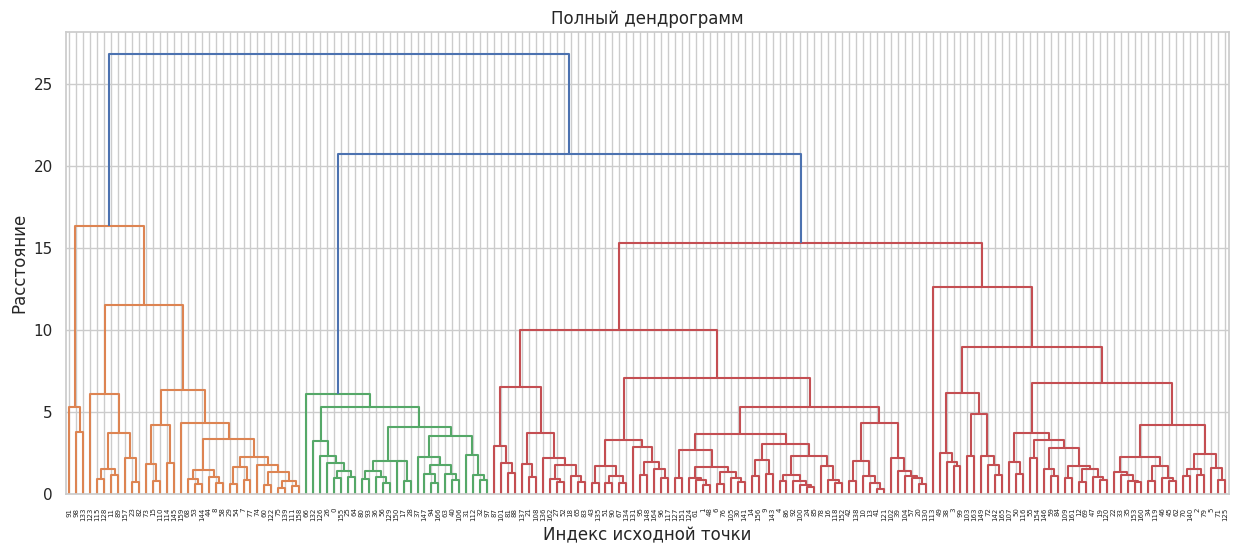

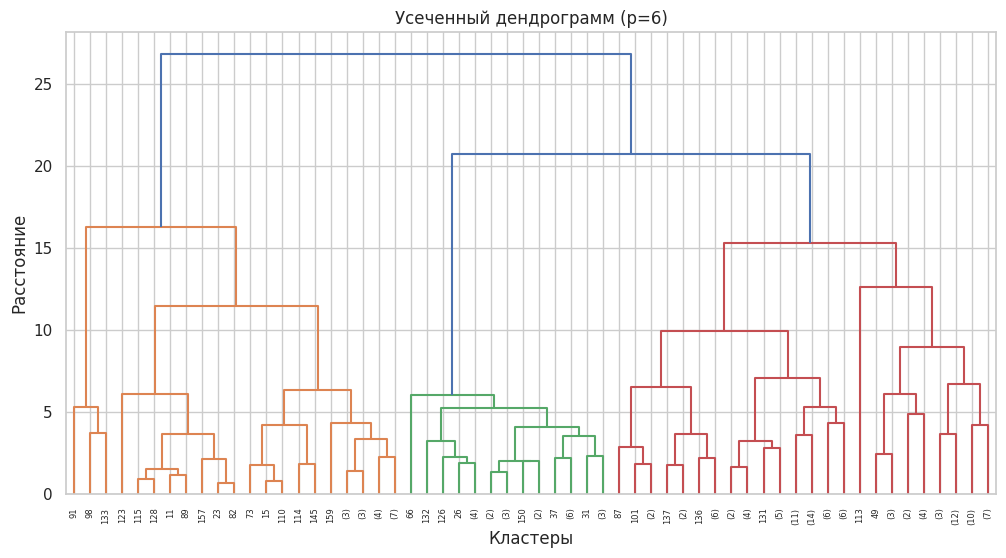

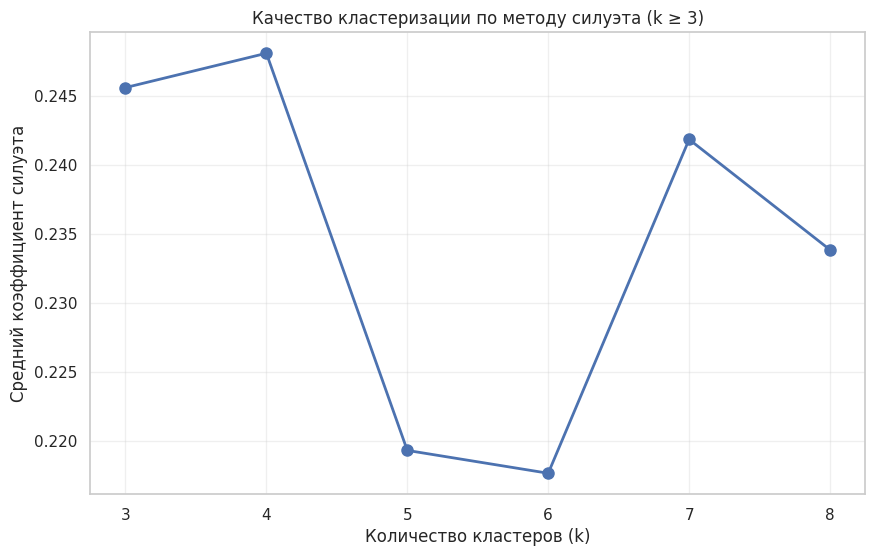

Выбранное k (иерархическая): 4 (силуэт = 0.248)


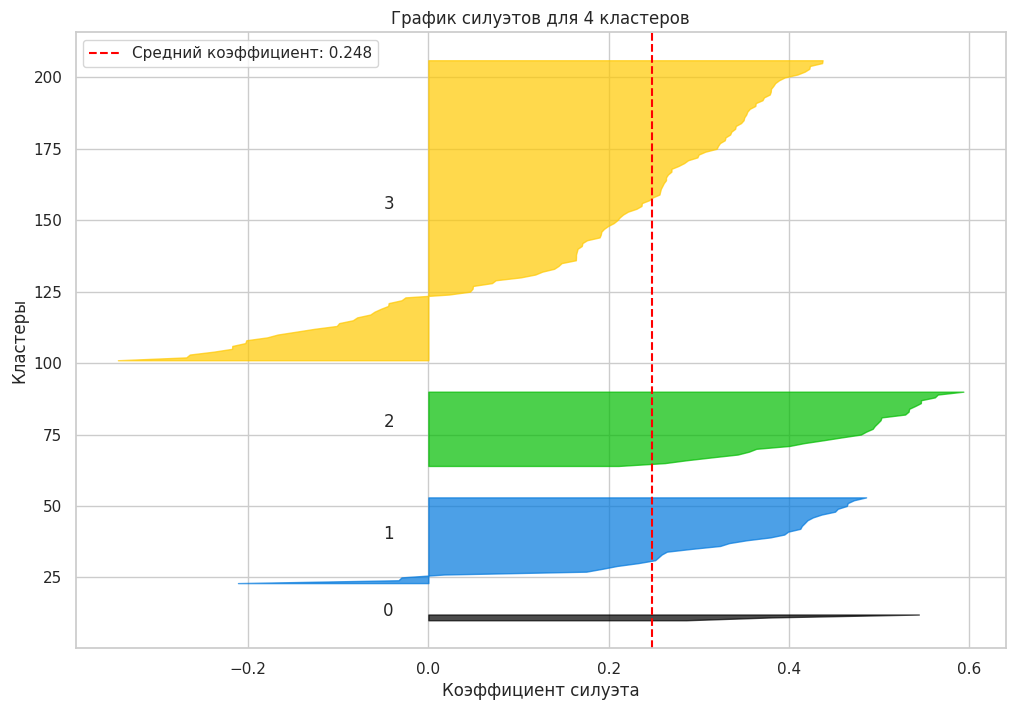


Статистика по кластерам:
Кластер 0: 3 точек (1.8%), средний силуэт: 0.404
Кластер 1: 31 точек (18.6%), средний силуэт: 0.303
Кластер 2: 27 точек (16.2%), средний силуэт: 0.454
Кластер 3: 106 точек (63.5%), средний силуэт: 0.175

Проверка: получено 4 кластеров: [0 1 2 3]


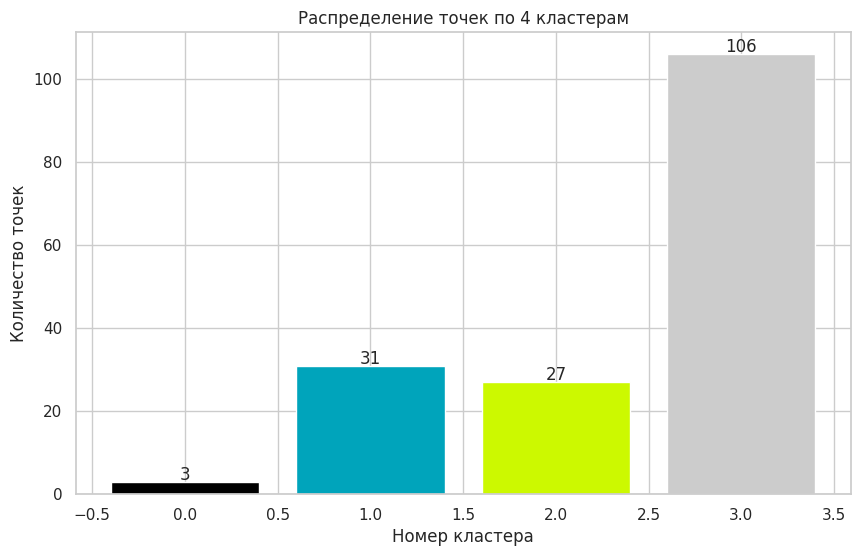


Итог: получено 4 кластеров с средним силуэтом 0.248


In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

# Иерархическая кластеризация
Z = linkage(Xs, method="ward")

# Полный дендрограмм
plt.figure(figsize=(15, 6))
dendrogram(Z)
plt.title("Полный дендрограмм")
plt.xlabel("Индекс исходной точки")
plt.ylabel("Расстояние")
plt.show()

# Усеченный дендрограмм
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode="level", p=6)
plt.title("Усеченный дендрограмм (p=6)")
plt.xlabel("Кластеры")
plt.ylabel("Расстояние")
plt.show()

# Анализ силуэтов для k от 3 до 8 (минимум 3 кластера!)
K = range(3, 9)  # от 3 до 8 кластеров
sils_h = []
for k in K:
    labs = fcluster(Z, k, criterion="maxclust") - 1
    sils_h.append(silhouette_score(Xs, labs))

plt.figure(figsize=(10, 6))
plt.plot(K, sils_h, "-o", markersize=8, linewidth=2)
plt.xlabel("Количество кластеров (k)")
plt.ylabel("Средний коэффициент силуэта")
plt.title("Качество кластеризации по методу силуэта (k ≥ 3)")
plt.grid(True, alpha=0.3)
plt.show()

# Автоматический выбор лучшего k (не менее 3 кластеров)
best_k_idx = np.argmax(sils_h)
best_k_h = K[best_k_idx]
print(f"Выбранное k (иерархическая): {best_k_h} (силуэт = {sils_h[best_k_idx]:.3f})")

# Детальный анализ силуэтов для лучшего k
best_labels = fcluster(Z, best_k_h, criterion="maxclust") - 1

# График силуэтов для лучшей кластеризации
plt.figure(figsize=(12, 8))

# Вычисляем силуэты для каждой точки
silhouette_vals = silhouette_samples(Xs, best_labels)

# Сортируем точки по кластерам и значениям силуэта
y_lower = 10
for i in range(best_k_h):
    cluster_silhouette_vals = silhouette_vals[best_labels == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / best_k_h)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, cluster_silhouette_vals,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

plt.axvline(x=np.mean(silhouette_vals), color="red", linestyle="--", 
            label=f"Средний коэффициент: {np.mean(silhouette_vals):.3f}")
plt.title(f"График силуэтов для {best_k_h} кластеров")
plt.xlabel("Коэффициент силуэта")
plt.ylabel("Кластеры")
plt.legend()
plt.show()

# Статистика по кластерам
print("\nСтатистика по кластерам:")
for i in range(best_k_h):
    cluster_size = np.sum(best_labels == i)
    cluster_silhouette = np.mean(silhouette_vals[best_labels == i])
    cluster_percentage = (cluster_size / len(best_labels)) * 100
    print(f"Кластер {i}: {cluster_size} точек ({cluster_percentage:.1f}%), средний силуэт: {cluster_silhouette:.3f}")

# Сохраняем результаты в DataFrame
df["hier_cluster"] = best_labels

# Проверка, что у нас действительно минимум 3 кластера
unique_clusters = np.unique(best_labels)
print(f"\nПроверка: получено {len(unique_clusters)} кластеров: {unique_clusters}")

# Дополнительная визуализация: распределение по кластерам
plt.figure(figsize=(10, 6))
cluster_counts = [np.sum(best_labels == i) for i in range(best_k_h)]
plt.bar(range(best_k_h), cluster_counts, color=cm.nipy_spectral(np.linspace(0, 1, best_k_h)))
plt.xlabel("Номер кластера")
plt.ylabel("Количество точек")
plt.title(f"Распределение точек по {best_k_h} кластерам")
for i, count in enumerate(cluster_counts):
    plt.text(i, count + 0.5, str(count), ha='center')
plt.show()

print(f"\nИтог: получено {best_k_h} кластеров с средним силуэтом {sils_h[best_k_idx]:.3f}")

In [42]:
df.head(15)
# df.describe()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster,hier_cluster,pca1,pca2
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.440,56.2,5.82,553,2,2,-2.913025,0.095621
1,Albania,16.6,28.0,6.55,48.6,9930,4.490,76.3,1.65,4090,0,3,0.429911,-0.588156
2,Algeria,27.3,38.4,4.17,31.4,12900,16.100,76.5,2.89,4460,0,3,-0.285225,-0.455174
3,Angola,119.0,62.3,2.85,42.9,5900,22.400,60.1,6.16,3530,2,3,-2.932423,1.695555
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.440,76.8,2.13,12200,0,3,1.033576,0.136659
5,Argentina,14.5,18.9,8.10,16.0,18700,20.900,75.8,2.37,10300,0,3,0.022407,-1.779187
6,Armenia,18.1,20.8,4.40,45.3,6700,7.770,73.3,1.69,3220,0,3,-0.101584,-0.568252
7,Australia,4.8,19.8,8.73,20.9,41400,1.160,82.0,1.93,51900,1,1,2.342165,-1.988459
8,Austria,4.3,51.3,11.00,47.8,43200,0.873,80.5,1.44,46900,1,1,2.973764,-0.734689
9,Azerbaijan,39.2,54.3,5.88,20.7,16000,13.800,69.1,1.92,5840,0,3,-0.181487,-0.402866


In [47]:
df['hier_cluster'].value_counts().sort_index()

0      3
1     31
2     27
3    106
Name: hier_cluster, dtype: int64

In [43]:
df.groupby('hier_cluster').mean(numeric_only=True)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster,pca1,pca2
hier_cluster,,,,,,,,,,,,
0,4.133333,176.000000,6.793333,156.666667,64033.333333,2.468000,81.433333,1.380000,57566.666667,4.000000,5.460225,5.432473
1,6.138710,47.138710,8.666452,38.474194,45996.774194,4.274935,79.841935,1.937742,41777.419355,0.870968,2.441239,-0.790478
2,105.070370,23.589630,6.507037,39.662963,1589.740741,7.142778,57.248148,5.433704,667.888889,2.000000,-2.823319,0.356783
3,31.617925,39.990368,6.353679,48.085527,11341.886792,9.120604,70.921698,2.654623,6407.367925,0.396226,-0.149335,-0.013450


In [44]:
df.groupby('hier_cluster').median(numeric_only=True)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster,pca1,pca2
hier_cluster,,,,,,,,,,,,
0,2.8,175.0,7.770,154.00,72100.0,3.620,81.3,1.360,46600.0,4.0,5.783376,4.849844
1,4.5,46.2,9.530,33.00,41100.0,1.570,80.4,1.920,41800.0,1.0,2.458960,-0.914481
2,101.0,22.2,5.690,39.20,1430.0,5.450,57.7,5.340,575.0,2.0,-2.864064,0.342733
3,20.5,37.3,6.015,49.25,9890.0,6.045,72.3,2.395,4520.0,0.0,-0.010850,-0.095683


In [54]:
for i in sorted(df['hier_cluster'].unique()):
    print(f"\nКластер {i}:")
    display(df[df['hier_cluster'] == i][['country', 'gdpp', 'income', 'child_mort', 'life_expec']].head(10))



Кластер 0:


,country,gdpp,income,child_mort,life_expec
91,Luxembourg,105000,91700,2.8,81.3
98,Malta,21100,28300,6.8,80.3
133,Singapore,46600,72100,2.8,82.7



Кластер 1:


,country,gdpp,income,child_mort,life_expec
7,Australia,51900,41400,4.8,82.0
8,Austria,46900,43200,4.3,80.5
11,Bahrain,20700,41100,8.6,76.0
15,Belgium,44400,41100,4.5,80.0
23,Brunei,35300,80600,10.5,77.1
29,Canada,47400,40700,5.6,81.3
44,Denmark,58000,44000,4.1,79.5
53,Finland,46200,39800,3.0,80.0
54,France,40600,36900,4.2,81.4
58,Germany,41800,40400,4.2,80.1



Кластер 2:


,country,gdpp,income,child_mort,life_expec
0,Afghanistan,553,1610,90.2,56.2
17,Benin,758,1820,111.0,61.8
25,Burkina Faso,575,1430,116.0,57.9
26,Burundi,231,764,93.6,57.7
28,Cameroon,1310,2660,108.0,57.3
31,Central African Republic,446,888,149.0,47.5
32,Chad,897,1930,150.0,56.5
36,Comoros,769,1410,88.2,65.9
37,"Congo, Dem. Rep.",334,609,116.0,57.5
40,Cote d'Ivoire,1220,2690,111.0,56.3



Кластер 3:


,country,gdpp,income,child_mort,life_expec
1,Albania,4090,9930,16.6,76.3
2,Algeria,4460,12900,27.3,76.5
3,Angola,3530,5900,119.0,60.1
4,Antigua and Barbuda,12200,19100,10.3,76.8
5,Argentina,10300,18700,14.5,75.8
6,Armenia,3220,6700,18.1,73.3
9,Azerbaijan,5840,16000,39.2,69.1
10,Bahamas,28000,22900,13.8,73.8
12,Bangladesh,758,2440,49.4,70.4
13,Barbados,16000,15300,14.2,76.7


| № кластера | Социально-экономический профиль                        | Ключевые показатели                                                                                        | Характеристика стран                                                                                          | Уровень нуждаемости |
| ---------- | ------------------------------------------------------ | ---------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------- | ------------------- |
| **0**      | **Высокоразвитые экспортно-ориентированные экономики** | Низкая смертность (~4), высокая жизнь (~81 год), доход ~64 тыс, экспорт/импорт >150% ВВП, рождаемость ~1.4 | Богатые страны с мощным внешнеторговым сектором, устойчивой экономикой и высоким качеством жизни.             | **Низкий**          |
| **1**      | **Развитые страны с устойчивой экономикой**            | Низкая смертность (~6), жизнь ~80 лет, доход ~46 тыс, рождаемость ~1.9, ВВП ~42 тыс                        | Высокие доходы и развитая медицина, умеренная инфляция и активная, но не доминирующая внешняя торговля.       | **Низкий–средний**  |
| **2**      | **Беднейшие развивающиеся страны**                     | Очень высокая смертность (~105), низкая жизнь (~57 лет), доход ~1.6 тыс, ВВП <1 тыс, рождаемость ~5.4      | Крайне низкие доходы, слабая экономика, высокая рождаемость и детская смертность. Основные получатели помощи. | **Высокий**         |
| **3**      | **Развивающиеся страны среднего уровня**               | Средняя смертность (~32), жизнь ~71 год, доход ~11 тыс, ВВП ~6.4 тыс, рождаемость ~2.7                     | Страны с растущей экономикой, умеренным уровнем жизни и социальной стабильностью, но уязвимые к инфляции.     | **Средний**         |


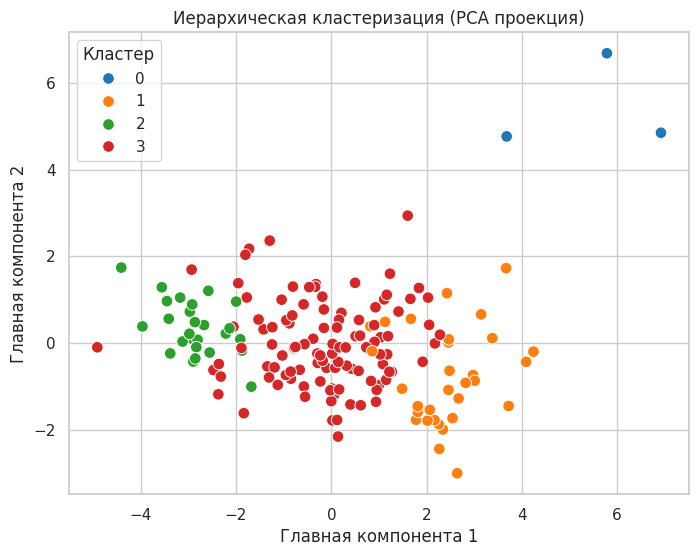

In [48]:
from sklearn.decomposition import PCA

# --- PCA до 2 компонент ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(Xs)

# --- Добавим координаты в DataFrame ---
df["pca1"] = X_pca[:, 0]
df["pca2"] = X_pca[:, 1]

# --- Визуализация кластеров ---
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x="pca1", y="pca2",
    hue="hier_cluster",
    palette="tab10",
    s=70
)
plt.title("Иерархическая кластеризация (PCA проекция)")
plt.xlabel("Главная компонента 1")
plt.ylabel("Главная компонента 2")
plt.legend(title="Кластер")
plt.show()


## DBSCAN: подбор eps через k-distance
Для DBSCAN используем MinMax-данные (X_mm). Построим k-distance (k = min_samples).

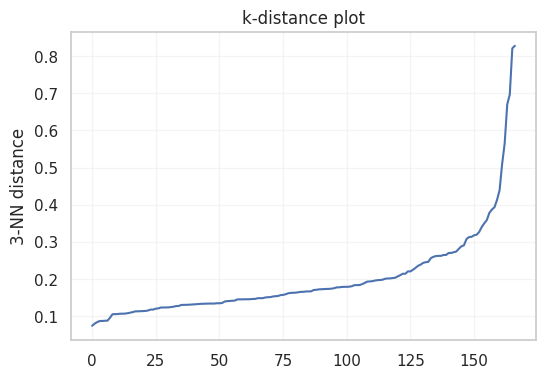

eps = 0.27068707374339385
silhouette = 0.1495742182568418


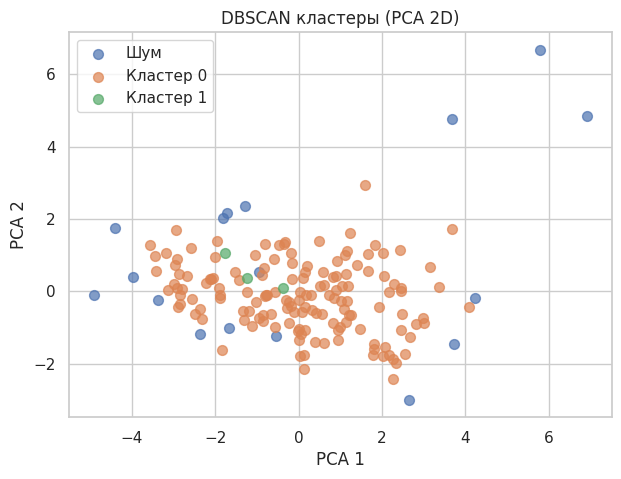

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score


# Подготовка данных
X = df[num_cols].dropna()
scaler = MinMaxScaler()
Xd = scaler.fit_transform(X)

# Поиск оптимального eps через k-distance plot
k = 3
nbrs = NearestNeighbors(n_neighbors=k).fit(Xd)
dists, _ = nbrs.kneighbors(Xd)
kdist = np.sort(dists[:, -1])
plt.figure(figsize=(6,4))
plt.plot(kdist); plt.ylabel(f"{k}-NN distance"); plt.title("k-distance plot"); plt.grid(alpha=0.2); plt.show()

# Подбор оптимального eps
eps_cand = np.percentile(kdist, [60,70,75,80,85,90])
best = (None, -99, None)

for e in eps_cand:
    labels = DBSCAN(eps=float(e), min_samples=k).fit_predict(Xd)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    if n_clusters > 1:
        sil = silhouette_score(Xd, labels)
        if sil > best[1]:
            best = (e, sil, labels)
    else:
        sil = -99

# Используем лучшие параметры или значения по умолчанию
if best[0] is not None:
    eps = best[0]
    labels_best = best[2]
    sil_best = best[1]
else:
    eps = 0.3
    dbscan = DBSCAN(eps=eps, min_samples=k)
    labels_best = dbscan.fit_predict(Xd)
    try:
        sil_best = silhouette_score(Xd, labels_best)
    except:
        sil_best = None

print("eps =", eps)
print("silhouette =", sil_best)
df["dbscan_cluster"] = labels_best

# Визуализация через PCA
X_scaled = StandardScaler().fit_transform(df[['child_mort','exports','health','imports',
                                              'income','inflation','life_expec','total_fer','gdpp']])

# PCA для 2D-проекции
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
df["pca1"], df["pca2"] = X_pca[:, 0], X_pca[:, 1]

# Визуализация
plt.figure(figsize=(7,5))
for c in sorted(df["dbscan_cluster"].unique()):
    subset = df[df["dbscan_cluster"] == c]
    label = "Шум" if c == -1 else f"Кластер {c}"
    plt.scatter(subset["pca1"], subset["pca2"], s=50, label=label, alpha=0.7)

plt.title("DBSCAN кластеры (PCA 2D)")
plt.xlabel("PCA 1"); plt.ylabel("PCA 2")
plt.legend()
plt.show()

In [114]:
summary = df.groupby("dbscan_cluster")[num_cols].mean().round(2)
display(summary)
print("Количество стран в каждом кластере:")
display(df["dbscan_cluster"].value_counts())


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
dbscan_cluster,,,,,,,,,
-1,66.05,59.49,7.45,60.46,29778.71,18.48,66.10,3.47,24962.35
0,34.53,39.44,6.63,44.55,15994.25,6.63,71.24,2.86,11809.37
1,64.00,18.63,12.43,84.50,1923.33,3.60,62.30,4.11,1559.00


Количество стран в каждом кластере:


 0    147
-1     17
 1      3
Name: dbscan_cluster, dtype: int64

# Вывод


### Сравнение методов кластеризации

В задаче были применены три метода кластеризации: **K-Means**, **иерархическая кластеризация** и **DBSCAN**.

* **Метод K-Means (k=5)** показал **наиболее устойчивый и интерпретируемый результат**.
  Границы кластеров логичны, результаты легко визуализируются при помощи PCA.
  Кластеры чётко разделяют страны по экономическому и социальному уровню.

* **Иерархическая кластеризация** с делением на **4 класса** дала схожий результат,
  однако один выброс (страна с крайне низкими показателями) был ошибочно отнесён к развивающимся,
  что снижает интерпретируемость результата.

* **DBSCAN** выделил **3 плотностных кластера**, но результат оказался менее осмысленным:
  из-за шумных и разнородных данных плотностной критерий не отражает реальных различий по уровню развития.
  Поэтому метод **хуже подходит** для задач, где важны социально-экономические закономерности,
  а не пространственная плотность данных.

**Вывод:** для данной задачи оптимальным методом является **K-Means с 5 кластерами**.

---

## **Интерпретация кластеров (K-Means, k=5)**

| Кластер | Ключевые характеристики                                                                | Интерпретация                                                                                                            | Приоритет помощи  |
| ------- | -------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------ | ----------------- |
| **0**   | Умеренная смертность (22), средний доход (12 тыс), жизнь 73 года, рождаемость 2.3   | **Развивающиеся, но стабильные страны** — имеют средний уровень жизни и здравоохранения, нуждаются в умеренной поддержке | Средний           |
| **1**   | Низкая смертность (5), высокий доход (40 тыс), жизнь 80 лет                         | **Развитые страны** (Европа, США, Канада и др.) — высокая устойчивость, хорошее здравоохранение                          | Низкий            |
| **2**   | Очень высокая смертность (90), низкий доход (3.5 тыс), жизнь 59 лет, рождаемость 5 | **Беднейшие страны мира** (Сахара, Центральная Африка) — нуждаются в приоритетной помощи                                 | **Высокий**       |
| **3**   | Смертность 130, гиперинфляция (104), доход 5 тыс, жизнь 60 лет                       | **Страны с экономическим и социальным кризисом** (гиперинфляция, нестабильность)                                         | **Очень высокий** |
| **4**   | Минимальная смертность (4), крайне высокий доход (60–70 тыс), высокий экспорт/импорт | **Богатые страны-экспортеры** (Сингапур, Швейцария, Люксембург) — экономически благополучные                             | Низкий            |

---

## **Эталонные страны каждого кластера**

| Кластер | Эталонная страна |
| ------- | ---------------- |
| 0       | **Suriname**     |
| 1       | **Finland**      |
| 2       | **Mozambique**   |
| 3       | **Nigeria**      |
| 4       | **Singapore**    |

---

## **Страны, нуждающиеся в помощи в первую очередь**

**Кластер 3 — критический уровень:**

* Представитель: **Nigeria** — крайне высокая детская смертность, низкая продолжительность жизни, гиперинфляция.
  → Страна требует **неотложной комплексной поддержки** (экономика, здравоохранение, инфраструктура).

**Кластер 2 — высокий приоритет:**

* Беднейшие страны с низким доходом, высокой смертностью и рождаемостью.
* Наиболее известные представители группы:
  **Bangladesh, India, Cambodia, Bolivia, Botswana.**

---

### Итоговое решение

Для принятия стратегических решений о распределении гуманитарной помощи
целесообразно использовать **результаты кластеризации K-Means**.
Она обеспечивает **наилучший баланс интерпретируемости и статистической устойчивости**.
В качестве **основных приоритетов помощи** следует выделить:

1. Страны из **кластера 3 (Nigeria)** — кризисная зона.
2. Страны из **кластера 2 (беднейшие регионы мира)** — высокий приоритет.
